## Introduction

Effective waste sorting is a critical component of modern recycling and waste-management systems. Manual inspection and classification of discarded materials are both time-consuming and prone to human error, leading to suboptimal recycling rates and increased environmental impact. Recent advances in computer vision—particularly single-stage object detectors like the YOLO (You Only Look Once) family—offer a promising path toward automating the detection and classification of waste items in real time.

In this notebook, a waste detection model using the Ultralytics YOLOv8 framework is presented. The workflow covers:

1. **Environment Setup:** Installing necessary Python packages (e.g., `gdown`, `ultralytics`) and importing core libraries for image processing and visualization.  
2. **Data Acquisition:** Downloading a custom waste dataset from Google Drive and unzipping it into a standardized directory structure.  
3. **Annotation Processing:** Converting polygon-based label files into YOLO’s bounding-box format.   
4. **Model Training:** Initializing a YOLOv8-n (nano) model, training over multiple epoch settings, and tracking validation mean Average Precision (mAP@0.5) to identify the best run.  
5. **Evaluation:** Running the best model on the validation and test sets to report mAP@0.5, mAP@0.75, and mAP@0.5:0.95, together with training curves to assess convergence behavior.   
6. **Improvement Strategies:** Suggesting how further refine the model to achieve higher accuracy and robustness in real-world waste-sorting applications.
7. **YOLO Generalization Performance:** Predicting box coordinates and classes on images not seen by the model during training.


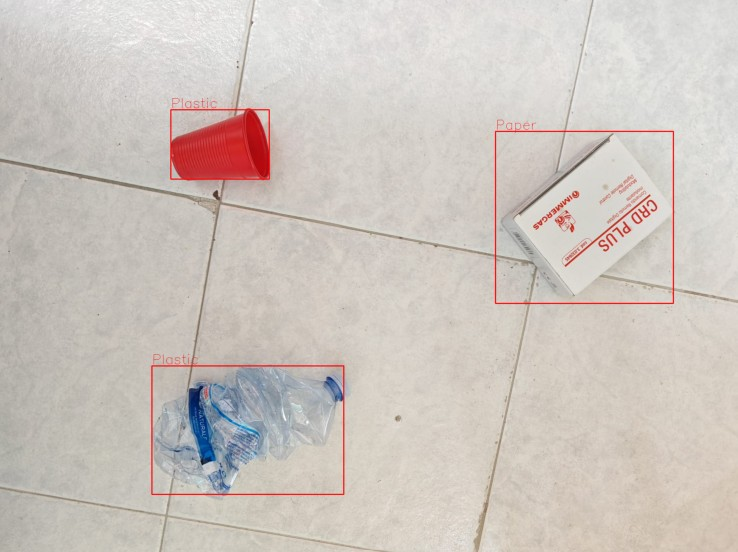

### Setup Environment and Install Dependencies

In [1]:
# Install required packages: gdown to download from Drive and ultralytics for YOLOv8.
!pip install --upgrade gdown ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
# Import libraries
import os
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import shutil
import matplotlib.pyplot as plt
import numpy as np
import glob
import yaml
from typing import List
import random
from pathlib import Path
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Download and Unzip the Dataset from Google Drive

In [3]:
# Download the zip file from Google Drive.
!gdown --fuzzy "https://drive.google.com/file/d/1zt5Kf7qV4Ctb9a4EpQ78GbTpBbMmYYxn/view?usp=sharing" -O dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1zt5Kf7qV4Ctb9a4EpQ78GbTpBbMmYYxn
From (redirected): https://drive.google.com/uc?id=1zt5Kf7qV4Ctb9a4EpQ78GbTpBbMmYYxn&confirm=t&uuid=09b9e82f-d6ab-4fe2-9b6e-4c3c1fbb36f5
To: /content/dataset.zip
100% 168M/168M [00:04<00:00, 36.3MB/s]


In [4]:
# Unzip the downloaded file into a folder named 'waste_detection'
!unzip -q dataset.zip -d waste_detection

### Data Visualization and Dataset Statistics

In [5]:
# Read the class names from the data.yaml file.
def read_data_yaml(yaml_path):
    """
    Reads the YAML configuration file and returns the class names.

    Parameters:
      - yaml_path: Path to the data.yaml file.

    Returns:
      - class_names: A list of class names read from the 'names' field.
    """
    with open(yaml_path, 'r') as stream:
        data_config = yaml.safe_load(stream)
    return data_config.get("names", [])

data_yaml_path = "waste_detection/data.yaml"
class_names = read_data_yaml(data_yaml_path)
print("Class names from data.yaml:", class_names)

Class names from data.yaml: ['Glass', 'Metal', 'Paper', 'Plastic', 'Waste']


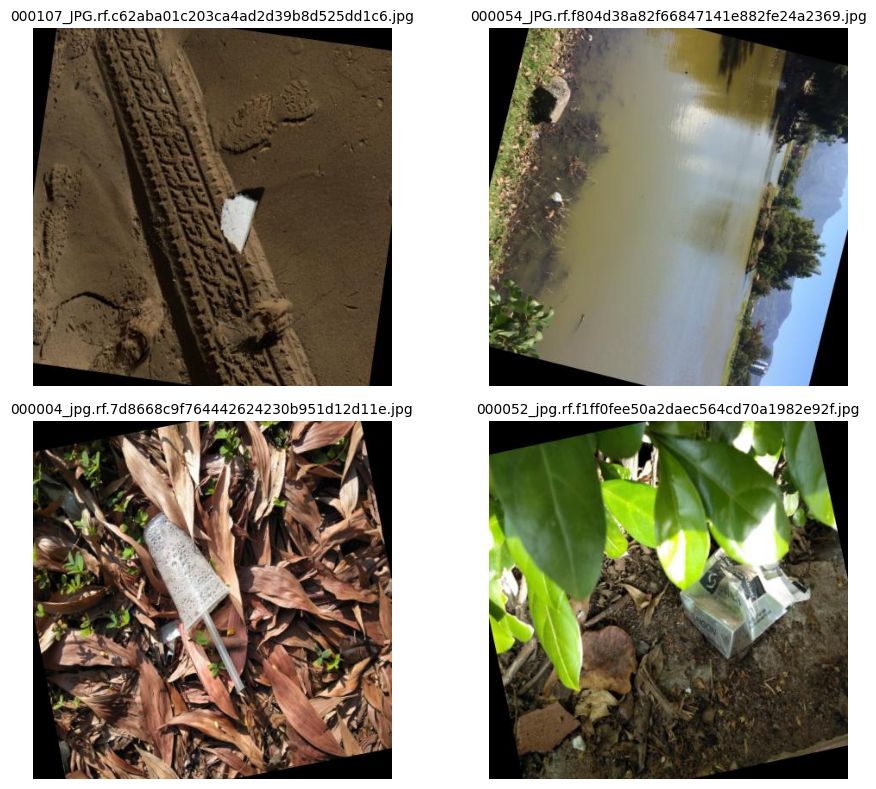

In [6]:
# To see what the downloaded images look like.
def display_random_images_from_folder(folder_path: str, image_extensions: List[str] = None, num_images: int = 4) -> None:
    """
    Selects and displays a grid of random images from a specified folder.

    Parameters:
        folder_path (str): Path to the folder containing image files.
        image_extensions (List[str], optional): List of accepted image file extensions. Defaults to ['.jpg', '.jpeg', '.png'].
        num_images (int): Number of random images to display. Default is 4.

    Raises:
        FileNotFoundError: If the folder does not exist or contains no valid images.
    """
    if image_extensions is None:
        image_extensions = ['.jpg', '.jpeg', '.png']

    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f"The folder path does not exist: {folder_path}")

    # Collect image files
    image_files = [f for f in os.listdir(folder_path)
                   if os.path.splitext(f)[1].lower() in image_extensions]

    if len(image_files) == 0:
        raise FileNotFoundError("No valid image files found in the folder.")

    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    # Display images using matplotlib
    plt.figure(figsize=(10, 8))
    for i, filename in enumerate(selected_files):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 2, i + 1)
        plt.imshow(image_rgb)
        plt.title(filename, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_random_images_from_folder("/content/waste_detection/train/images")

In [7]:
# Take a look at the label file structure
def read_text_file(file_path):
    """
    Reads the content of a text file and prints it.

    Parameters:
        file_path (str): The path to the text file.
        """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            print(content)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

text_path = '/content/waste_detection/train/labels/000000_JPG.rf.218a2db3768c44d08d25ce46bd45590d.txt'
read_text_file(text_path)

3 0.4089052283653846 0.6262254903846153 0.41217320192307694 0.6341911754807692 0.42238562019230774 0.6412377451923077 0.4354575168269231 0.6455269615384616 0.4485294110576923 0.6470588245192308 0.4599673197115385 0.6476715697115385 0.47344771153846155 0.6458333341346154 0.4799836610576923 0.6424632355769231 0.48161764663461537 0.6369485288461539 0.4787581706730769 0.630821079326923 0.4787581706730769 0.6243872548076923 0.48406862740384615 0.6087622548076923 0.486111110576923 0.5958946081730769 0.4857026153846154 0.587622548076923 0.48488562019230774 0.5814950985576923 0.47916666586538464 0.5762867644230769 0.46977124278846155 0.5735294110576923 0.46119281009615387 0.57414215625 0.44812091586538466 0.5765931370192308 0.44362745192307695 0.5805759807692308 0.43341503365384615 0.5949754903846154 0.423611110576923 0.6142769615384616 0.4207516346153846 0.6179534302884615 0.41421568509615386 0.6207107836538461 0.4089052283653846 0.6262254903846153
2 0.4456699350961539 0.7879901971153846 0.43

The annotation files do not follow the typical YOLO format. For each image, there should be a corresponding text file in which each line represents one object with exactly five values:
*   The first value is the class index (an integer).
*   The next four values are the normalized coordinates: x_center, y_center, width, and height.

However, the downloaded label files contain lines that begin with a single number corresponding to the class, followed by many additional numbers.
This discrepancy suggests that the files may be using a different format—perhaps one that encodes polygons.
Polygon annotations represent object boundaries using a series of points (vertices) that form a closed shape.
To convert polygon annotations to YOLO’s bounding box format, the smallest axis-aligned rectangle that fully encloses the polygon is computed. This is done by:
1.   Extracting all the x and y coordinates from the polygon.
2.   Calculating the minimum and maximum values:
  *   min_x, max_x: Minimum and maximum x-coordinates.
  *   min_y, max_y: Minimum and maximum y-coordinates.

3.   Deriving the bounding box parameters:
  *   x_center = (min_x + max_x) / 2
  *   y_center = (min_y + max_y) / 2
  *   width = max_x - min_x
  *   height = max_y - min_y

In [8]:
def polygon_to_bbox(polygon):
    """
    Convert a list of polygon coordinates to a bounding box.
    Returns x_center, y_center, width, height
    """
    xs = polygon[0::2]
    ys = polygon[1::2]
    min_x = min(xs)
    max_x = max(xs)
    min_y = min(ys)
    max_y = max(ys)

    x_center = (min_x + max_x) / 2.0
    y_center = (min_y + max_y) / 2.0
    width = max_x - min_x
    height = max_y - min_y
    return x_center, y_center, width, height

def convert_polygon_to_yolo_lines(input_file):
    """
    Converts polygon annotations to YOLO format.
    Returns a list of converted lines as strings.
    """
    yolo_lines = []
    with open(input_file, 'r') as f_in:
        for line in f_in:
            line = line.strip()
            if not line:
                continue
            tokens = line.split()
            cls = tokens[0]
            try:
                coords = list(map(float, tokens[1:]))
            except ValueError:
                print("Error parsing line (non-numeric coordinates):", line)
                continue

            if len(coords) % 2 != 0:
                print("Invalid number of coordinates in line:", line)
                continue

            x_center, y_center, width, height = polygon_to_bbox(coords)
            yolo_line = f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
            yolo_lines.append(yolo_line)

    return yolo_lines

yolo_formatted_lines = convert_polygon_to_yolo_lines(text_path)
# Print each converted line
for line in yolo_formatted_lines:
    print(line)

3 0.447508 0.610600 0.077206 0.074142
2 0.419935 0.786305 0.063725 0.057292
4 0.530637 0.591299 0.034314 0.036152


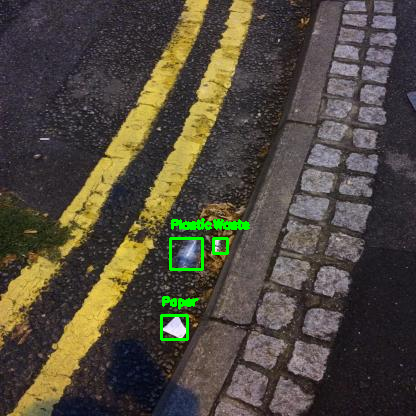

In [9]:
def visualize_polygon_annotations(image_path, label_path, class_list):
    """
    Loads an image and its corresponding polygon annotations,
    converts polygons to YOLO bounding boxes, and visualizes them in Colab.
    Displays class names instead of indices with larger text.
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return

    # Get image dimensions
    height, width = image.shape[:2]

    # Get YOLO-format bounding boxes
    yolo_boxes = convert_polygon_to_yolo_lines(label_path)

    for yolo_line in yolo_boxes:
        tokens = yolo_line.strip().split()
        cls_idx = int(tokens[0])
        cls_name = class_list[cls_idx] if 0 <= cls_idx < len(class_list) else f"class_{cls_idx}"
        x_center, y_center, w, h = map(float, tokens[1:])

        # Convert normalized YOLO values to pixel coordinates
        x_center *= width
        y_center *= height
        w *= width
        h *= height

        # Calculate top-left and bottom-right coordinates
        x1 = int(x_center - w / 2)
        y1 = int(y_center - h / 2)
        x2 = int(x_center + w / 2)
        y2 = int(y_center + h / 2)

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

        # Draw the class name above the box
        font_scale = 0.4
        thickness = 2
        text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        text_w, text_h = text_size

        text_x = x1
        text_y = max(y1 - 10, text_h + 5)

        cv2.putText(image, cls_name, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

    # Show image inline in Colab
    cv2_imshow(image)


image_path = "waste_detection/train/images/000000_JPG.rf.218a2db3768c44d08d25ce46bd45590d.jpg"
label_path = "waste_detection/train/labels/000000_JPG.rf.218a2db3768c44d08d25ce46bd45590d.txt"
visualize_polygon_annotations(image_path, label_path, class_names)

### YOLO training

In [10]:
# Count the number of image files in the images subfolder of train, valid and test

def count_images_in_folder(base_path):
    """
    Counts the number of image files in the 'train', 'valid', and 'test' splits of a dataset directory.

    Args:
        base_path (str): The base directory path containing 'train', 'valid', and 'test' subdirectories,
                         each with an 'images' folder inside.

    Returns:
        dict: A dictionary with the split names ('train', 'valid', 'test') as keys and the corresponding
              number of image files as values.
              """

    splits = ['train', 'valid', 'test']
    image_counts = {}

    for split in splits:
        image_folder = os.path.join(base_path, split, 'images')
        if os.path.exists(image_folder):
            count = len([f for f in os.listdir(image_folder)
                         if os.path.isfile(os.path.join(image_folder, f))
                         and f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            image_counts[split] = count
        else:
            image_counts[split] = 0

    return image_counts

base_path = 'waste_detection'
results = count_images_in_folder(base_path)

for split, count in results.items():
    print(f"Number of images in {split}: {count}")

Number of images in train: 3502
Number of images in valid: 580
Number of images in test: 45


In [11]:
# For each split (train, valid, test) report how many images contain each of your five classes:

def count_images_per_class(dataset_dir: str,
                           split: str,
                           class_names: list[str]) -> dict[str, int]:
    """
    Counts how many images in a given split contain each class.

    Args:
      dataset_dir: path to root of your waste_detection folder
      split: one of 'train', 'valid', or 'test'
      class_names: list of class names in order of their class‐ids

    Returns:
      A dict mapping each class name → number of images containing it
    """
    labels_dir = os.path.join(dataset_dir, split, 'labels')
    counts = {cls: 0 for cls in class_names}

    for fname in os.listdir(labels_dir):
        if not fname.endswith('.txt'):
            continue
        seen = set()
        with open(os.path.join(labels_dir, fname), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                cls_id = int(parts[0])
                seen.add(cls_id)
        # increment each class that appeared at least once in this image
        for cls_id in seen:
            counts[class_names[cls_id]] += 1

    return counts


def report_all_splits(dataset_dir: str,
                      splits: list[str],
                      class_names: list[str]) -> None:
    """
    Prints a per-class image count summary for each dataset split.

    Args:
        dataset_dir (str): The root directory of the dataset containing the splits (e.g., 'train', 'valid', 'test').
        splits (list of str): List of split names to process (e.g., ['train', 'valid', 'test']).
        class_names (list of str): List of class names to count images for.

    Returns:
        None
    """
    for split in splits:
        cnts = count_images_per_class(dataset_dir, split, class_names)
        print(f"=== {split.upper()} ===")
        for cls, c in cnts.items():
            print(f"{cls:7s}: {c}")
        print()

SPLITS = ['train', 'valid', 'test']

report_all_splits(base_path, SPLITS, class_names)

=== TRAIN ===
Glass  : 42
Metal  : 727
Paper  : 1167
Plastic: 2403
Waste  : 841

=== VALID ===
Glass  : 51
Metal  : 123
Paper  : 142
Plastic: 393
Waste  : 92

=== TEST ===
Glass  : 1
Metal  : 6
Paper  : 15
Plastic: 33
Waste  : 11



In [15]:
def process_dataset_folder(dataset_folder):
  """
  Processes all label files in a dataset folder by converting them to YOLO format.

  Args:
      dataset_folder (str): The path to the dataset directory containing a 'labels' subfolder.
  """

  label_folder = os.path.join(dataset_folder, "labels") # fixed the indentation here

  if not os.path.exists(label_folder):
      print(f"Label folder not found: {label_folder}")
      return

  count = 0
  for filename in os.listdir(label_folder):
      if not filename.endswith(".txt"):
          continue

      input_path = os.path.join(label_folder, filename)

      yolo_lines = convert_polygon_to_yolo_lines(input_path)

      # Overwrite the original file with YOLO format
      with open(input_path, 'w') as f_out:
          for line in yolo_lines:
              f_out.write(line + '\n')
      count += 1

# Run conversion for each dataset
base_path = "/content/waste_detection"
for split in ["train", "valid", "test"]:
    split_path = os.path.join(base_path, split)
    process_dataset_folder(split_path)

Before training the YOLO model, if you are using google colab you should manually update the train, val, and test paths in the data.yaml file as follows:

*   train: /content/waste_detection/train/images
*   val: /content/waste_detection/valid/images
*   test: /content/waste_detection/test/images

In [16]:
# Path definition
DATA_DIR  = Path('/content/waste_detection')
DATA_YAML = DATA_DIR / 'data.yaml'
TEST_DIR  = DATA_DIR / 'test'

In [17]:
# Define a list of epoch values to try
# Train one model for each number of epochs and pick the best.
epoch_list = [10, 20, 40]

In [ ]:
best_map50 = 0.0    # track highest validation mAP@0.5
best_run   = None   # store the run object for the best model

for epochs in epoch_list:
    print(f"\n=== Training for {epochs} epochs ===")

    # Initialize a fresh YOLOv8 nano model
    model = YOLO('yolov8n.pt')

    # Train on training data for the specified number of epochs
    run = model.train(
        data=str(DATA_YAML),      # path to data.yaml
        epochs=epochs,            # hyper‑parameter
        name=f"exp_epochs_{epochs}",
        exist_ok=True             # overwrite if that experiment name exists
    )

    # After training
    results = model.val(data=str(DATA_YAML)) # Computes detection metrics (precision, recall) on validation data and aggregates them into mean average precision (mAP) curves.
    map50   = results.box.map50
    print(f"Validation mAP@0.5 after {epochs} epochs: {map50:.3f}")

    # If this is our best so far, remember it
    if map50 > best_map50:
        best_map50 = map50
        best_run   = run


=== Training for 10 epochs ===


100%|██████████| 6.25M/6.25M [00:00<00:00, 305MB/s]


Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/waste_detection/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=exp_epochs_10, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

100%|██████████| 755k/755k [00:00<00:00, 115MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,823 parameters, 3,011,807 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 363MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1127.1±709.5 MB/s, size: 41.4 KB)


train: Scanning /content/waste_detection/train/labels... 3502 images, 27 backgrounds, 0 corrupt: 100%|██████████| 3502/3502 [00:01<00:00, 2396.05it/s]


train: New cache created: /content/waste_detection/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 607.8±344.1 MB/s, size: 39.6 KB)


val: Scanning /content/waste_detection/valid/labels... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:00<00:00, 822.90it/s]


val: New cache created: /content/waste_detection/valid/labels.cache
Plotting labels to runs/detect/exp_epochs_10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/exp_epochs_10
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.5G      1.378      3.416      1.266         29        640: 100%|██████████| 219/219 [01:01<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.95it/s]


                   all        580       1319      0.322      0.204      0.115     0.0757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.98G      1.445      2.829      1.313         33        640: 100%|██████████| 219/219 [00:55<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


                   all        580       1319      0.318      0.185      0.101     0.0639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         3G      1.455      2.546      1.308         62        640: 100%|██████████| 219/219 [00:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]


                   all        580       1319      0.363      0.192      0.117     0.0752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.02G       1.45      2.361      1.298         46        640: 100%|██████████| 219/219 [00:54<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.05it/s]


                   all        580       1319      0.353      0.188      0.116     0.0736

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.03G      1.394      2.225      1.273         38        640: 100%|██████████| 219/219 [00:55<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.92it/s]

                   all        580       1319       0.35      0.216      0.136     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.05G       1.34      2.094      1.232         51        640: 100%|██████████| 219/219 [00:54<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.34it/s]

                   all        580       1319      0.359       0.23      0.162      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.06G      1.297      1.988      1.197         37        640: 100%|██████████| 219/219 [00:54<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.14it/s]

                   all        580       1319      0.397       0.26       0.18      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.08G      1.238      1.872      1.169         29        640: 100%|██████████| 219/219 [00:54<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]

                   all        580       1319      0.399      0.253      0.182      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       3.1G      1.197       1.79      1.144         48        640: 100%|██████████| 219/219 [00:54<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.55it/s]

                   all        580       1319      0.398      0.248      0.189      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.12G      1.158      1.688      1.116         54        640: 100%|██████████| 219/219 [00:53<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.08it/s]

                   all        580       1319      0.414      0.245      0.189      0.138



10 epochs completed in 0.170 hours.
Optimizer stripped from runs/detect/exp_epochs_10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/exp_epochs_10/weights/best.pt, 6.2MB

Validating runs/detect/exp_epochs_10/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]


                   all        580       1319        0.4      0.247      0.189      0.141
                 Glass         51         69          1          0     0.0235     0.0169
                 Metal        123        209      0.269      0.378      0.242      0.188
                 Paper        142        267      0.227      0.232      0.152      0.111
               Plastic        393        633      0.408      0.573      0.489      0.364
                 Waste         92        141      0.094     0.0496     0.0403     0.0265
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/exp_epochs_10
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 965.4±575.0 MB/s, size: 26.7 KB)


val: Scanning /content/waste_detection/valid/labels.cache... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:07<00:00,  4.86it/s]


                   all        580       1319        0.4      0.248       0.19      0.141
                 Glass         51         69          1          0     0.0235      0.017
                 Metal        123        209      0.273      0.381      0.244      0.187
                 Paper        142        267      0.226      0.232      0.152      0.111
               Plastic        393        633      0.409      0.577       0.49      0.364
                 Waste         92        141     0.0944     0.0496     0.0402     0.0264
Speed: 0.5ms preprocess, 4.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/exp_epochs_10
Validation mAP@0.5 after 10 epochs: 0.190

=== Training for 20 epochs ===
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/waste_detection/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, 

train: Scanning /content/waste_detection/train/labels.cache... 3502 images, 27 backgrounds, 0 corrupt: 100%|██████████| 3502/3502 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 722.8±432.3 MB/s, size: 39.6 KB)


val: Scanning /content/waste_detection/valid/labels.cache... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:00<?, ?it/s]


Plotting labels to runs/detect/exp_epochs_20/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/exp_epochs_20
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.42G      1.385      3.157      1.284         50        640: 100%|██████████| 219/219 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


                   all        580       1319      0.316      0.197      0.101     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.42G      1.449      2.638      1.317        103        640: 100%|██████████| 219/219 [01:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.96it/s]


                   all        580       1319      0.315      0.187     0.0856     0.0519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.42G      1.463      2.437      1.338         43        640: 100%|██████████| 219/219 [00:59<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]

                   all        580       1319      0.326      0.162      0.084     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.42G      1.487      2.352      1.349         65        640: 100%|██████████| 219/219 [00:59<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]

                   all        580       1319      0.342      0.191      0.122     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.42G      1.426      2.217      1.315         74        640: 100%|██████████| 219/219 [00:59<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]

                   all        580       1319      0.352      0.202       0.13     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.42G      1.375      2.119      1.298        106        640: 100%|██████████| 219/219 [00:59<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.14it/s]


                   all        580       1319      0.349      0.201      0.119     0.0775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.42G      1.362      2.074      1.281         33        640: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]

                   all        580       1319      0.174      0.173      0.134     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.61G      1.329      2.006      1.257         45        640: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.07it/s]


                   all        580       1319      0.349      0.209      0.133      0.091

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.61G      1.303      1.946      1.231         41        640: 100%|██████████| 219/219 [00:59<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.14it/s]


                   all        580       1319      0.396      0.204      0.144     0.0982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.61G      1.288      1.905      1.231         84        640: 100%|██████████| 219/219 [00:59<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.05it/s]

                   all        580       1319       0.38      0.211      0.171      0.121


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.61G      1.272      1.885      1.198         49        640: 100%|██████████| 219/219 [00:58<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]

                   all        580       1319        0.4      0.216      0.175      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.61G      1.235      1.812      1.177         57        640: 100%|██████████| 219/219 [00:56<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.27it/s]

                   all        580       1319      0.417      0.233      0.178      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.61G      1.209      1.762      1.164         26        640: 100%|██████████| 219/219 [00:55<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.55it/s]

                   all        580       1319      0.381      0.261      0.164      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.61G      1.183        1.7      1.146         51        640: 100%|██████████| 219/219 [00:55<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]


                   all        580       1319      0.391      0.253      0.191      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.61G      1.158      1.606      1.119         17        640: 100%|██████████| 219/219 [00:55<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]

                   all        580       1319      0.395      0.266      0.198       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.61G      1.134      1.566      1.104         34        640: 100%|██████████| 219/219 [00:57<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.14it/s]

                   all        580       1319      0.415      0.252      0.197      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.61G      1.108      1.501       1.09         51        640: 100%|██████████| 219/219 [00:54<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]

                   all        580       1319      0.444       0.24        0.2      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.61G      1.106      1.453      1.089         24        640: 100%|██████████| 219/219 [00:55<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.27it/s]

                   all        580       1319      0.439      0.245      0.206      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.61G      1.073      1.405       1.07         32        640: 100%|██████████| 219/219 [00:56<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.33it/s]

                   all        580       1319       0.43      0.269      0.208       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.61G      1.073      1.362       1.07         30        640: 100%|██████████| 219/219 [00:56<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.18it/s]

                   all        580       1319      0.241      0.257      0.203      0.147



20 epochs completed in 0.351 hours.
Optimizer stripped from runs/detect/exp_epochs_20/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/exp_epochs_20/weights/best.pt, 6.2MB

Validating runs/detect/exp_epochs_20/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]


                   all        580       1319       0.43      0.269      0.208       0.15
                 Glass         51         69          1          0     0.0255     0.0208
                 Metal        123        209      0.336      0.416      0.264      0.203
                 Paper        142        267      0.267      0.217      0.187      0.127
               Plastic        393        633      0.415      0.586      0.495      0.357
                 Waste         92        141      0.133      0.128     0.0671     0.0416
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/exp_epochs_20
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 761.8±380.8 MB/s, size: 26.7 KB)


val: Scanning /content/waste_detection/valid/labels.cache... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.43it/s]


                   all        580       1319       0.43      0.269      0.208       0.15
                 Glass         51         69          1          0     0.0256     0.0209
                 Metal        123        209      0.336      0.416      0.264      0.203
                 Paper        142        267      0.267      0.217      0.187      0.127
               Plastic        393        633      0.414      0.586      0.495      0.358
                 Waste         92        141      0.134      0.128      0.067     0.0412
Speed: 1.0ms preprocess, 3.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/exp_epochs_20
Validation mAP@0.5 after 20 epochs: 0.208

=== Training for 40 epochs ===
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/waste_detection/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, 

train: Scanning /content/waste_detection/train/labels.cache... 3502 images, 27 backgrounds, 0 corrupt: 100%|██████████| 3502/3502 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 317.8±79.9 MB/s, size: 39.6 KB)


val: Scanning /content/waste_detection/valid/labels.cache... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:00<?, ?it/s]


Plotting labels to runs/detect/exp_epochs_40/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/exp_epochs_40
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.38G      1.385      3.157      1.284         50        640: 100%|██████████| 219/219 [01:03<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


                   all        580       1319      0.316      0.197      0.101     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      2.38G      1.456      2.662      1.322        103        640: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.61it/s]


                   all        580       1319      0.332      0.189     0.0995      0.061

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      2.38G      1.478       2.44      1.342         43        640: 100%|██████████| 219/219 [00:58<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.45it/s]

                   all        580       1319      0.346      0.195      0.101     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      2.38G      1.497      2.364      1.349         65        640: 100%|██████████| 219/219 [00:58<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.42it/s]


                   all        580       1319      0.309      0.197      0.118     0.0732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      2.38G      1.441       2.25      1.323         74        640: 100%|██████████| 219/219 [00:57<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.98it/s]


                   all        580       1319      0.352      0.178      0.129     0.0823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      2.38G      1.411      2.155      1.311        106        640: 100%|██████████| 219/219 [00:58<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.11it/s]


                   all        580       1319      0.403      0.191      0.147     0.0952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      2.38G        1.4      2.122      1.298         33        640: 100%|██████████| 219/219 [00:58<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.22it/s]

                   all        580       1319      0.395      0.158      0.131     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.57G      1.366      2.056      1.275         45        640: 100%|██████████| 219/219 [00:58<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.00it/s]


                   all        580       1319      0.336      0.232      0.145     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.57G      1.339      2.002      1.255         41        640: 100%|██████████| 219/219 [00:59<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.84it/s]


                   all        580       1319      0.368       0.21      0.148        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.57G       1.33      1.984      1.252         84        640: 100%|██████████| 219/219 [01:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.44it/s]

                   all        580       1319       0.41      0.232      0.169      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         3G      1.305      1.921       1.23        101        640: 100%|██████████| 219/219 [00:58<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.34it/s]

                   all        580       1319      0.193      0.226      0.161      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         3G      1.311      1.904      1.228         65        640: 100%|██████████| 219/219 [00:58<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]


                   all        580       1319      0.373      0.215      0.156      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         3G      1.297      1.878      1.225         43        640: 100%|██████████| 219/219 [00:58<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.41it/s]

                   all        580       1319      0.405      0.215      0.168      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         3G       1.28      1.838      1.217         41        640: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]

                   all        580       1319      0.397      0.241      0.159      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         3G      1.271      1.826      1.213         52        640: 100%|██████████| 219/219 [00:59<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.48it/s]

                   all        580       1319      0.397      0.242       0.17      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.02G      1.242      1.788      1.195         52        640: 100%|██████████| 219/219 [00:59<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.43it/s]

                   all        580       1319      0.186      0.239      0.165      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.03G      1.238      1.744      1.187         52        640: 100%|██████████| 219/219 [01:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.27it/s]

                   all        580       1319      0.395      0.269      0.185      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.03G      1.219      1.706      1.182         65        640: 100%|██████████| 219/219 [01:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]

                   all        580       1319      0.367      0.269      0.158      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.03G      1.214      1.672      1.169         72        640: 100%|██████████| 219/219 [01:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.03it/s]

                   all        580       1319      0.191      0.217      0.183      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.03G      1.206      1.636      1.165         48        640: 100%|██████████| 219/219 [01:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.12it/s]

                   all        580       1319      0.403      0.241      0.164      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      3.03G      1.196      1.633      1.166         67        640: 100%|██████████| 219/219 [01:00<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.88it/s]


                   all        580       1319      0.445      0.218      0.198       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.03G      1.192      1.604      1.167         54        640: 100%|██████████| 219/219 [00:59<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.49it/s]


                   all        580       1319      0.195      0.263      0.167       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.03G      1.171      1.566       1.15         52        640: 100%|██████████| 219/219 [00:59<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.44it/s]

                   all        580       1319      0.422      0.233      0.188      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      3.03G      1.175      1.535      1.148         64        640: 100%|██████████| 219/219 [00:59<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.35it/s]

                   all        580       1319      0.384      0.243       0.16      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.03G      1.148      1.493      1.137         67        640: 100%|██████████| 219/219 [01:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.55it/s]

                   all        580       1319      0.193      0.255       0.18       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.03G      1.138      1.455      1.135         60        640: 100%|██████████| 219/219 [01:00<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.99it/s]

                   all        580       1319      0.413      0.251      0.181      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.03G      1.138      1.434      1.126         44        640: 100%|██████████| 219/219 [00:58<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]

                   all        580       1319      0.413      0.225      0.177      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.31G      1.115      1.418      1.121         43        640: 100%|██████████| 219/219 [00:58<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.96it/s]

                   all        580       1319      0.435      0.245      0.184      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.33G      1.106      1.377      1.114         49        640: 100%|██████████| 219/219 [00:58<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.93it/s]

                   all        580       1319      0.418       0.22      0.177      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.33G      1.127      1.357      1.108        113        640: 100%|██████████| 219/219 [00:58<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.43it/s]

                   all        580       1319      0.223      0.241      0.187      0.137


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.33G      1.086      1.326      1.077         58        640: 100%|██████████| 219/219 [00:57<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]

                   all        580       1319      0.473      0.211      0.186      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.33G      1.066      1.249      1.062         37        640: 100%|██████████| 219/219 [00:55<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.56it/s]

                   all        580       1319      0.459      0.216      0.188      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.33G      1.045      1.215       1.06         25        640: 100%|██████████| 219/219 [00:55<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.32it/s]

                   all        580       1319      0.426      0.239      0.186      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.33G      1.031      1.173      1.047         64        640: 100%|██████████| 219/219 [00:55<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]

                   all        580       1319      0.243      0.251      0.195      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.33G      1.034      1.166      1.048         53        640: 100%|██████████| 219/219 [00:59<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.24it/s]

                   all        580       1319       0.24       0.25      0.191      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.33G      1.022      1.103      1.041         61        640: 100%|██████████| 219/219 [00:55<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.52it/s]

                   all        580       1319      0.227      0.245      0.189      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.33G       1.01      1.086      1.032         78        640: 100%|██████████| 219/219 [00:54<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.32it/s]

                   all        580       1319      0.234      0.244      0.199      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.33G      1.001      1.056      1.027         29        640: 100%|██████████| 219/219 [00:56<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.15it/s]

                   all        580       1319      0.234      0.249      0.192      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.33G     0.9864      1.032      1.021         20        640: 100%|██████████| 219/219 [00:56<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]

                   all        580       1319      0.247      0.242       0.19      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.33G     0.9845      1.019      1.021         36        640: 100%|██████████| 219/219 [00:56<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.47it/s]

                   all        580       1319      0.228      0.242       0.19      0.142



40 epochs completed in 0.714 hours.
Optimizer stripped from runs/detect/exp_epochs_40/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/exp_epochs_40/weights/best.pt, 6.2MB

Validating runs/detect/exp_epochs_40/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


                   all        580       1319      0.235      0.247      0.199      0.146
                 Glass         51         69          0          0     0.0246     0.0175
                 Metal        123        209      0.334      0.368      0.264       0.21
                 Paper        142        267      0.266      0.219      0.161      0.111
               Plastic        393        633      0.471      0.556      0.484      0.356
                 Waste         92        141      0.105     0.0922     0.0605     0.0379
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/exp_epochs_40
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 899.7±444.8 MB/s, size: 26.7 KB)


val: Scanning /content/waste_detection/valid/labels.cache... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:06<00:00,  5.63it/s]


                   all        580       1319      0.235      0.244      0.199      0.147
                 Glass         51         69          0          0     0.0248     0.0176
                 Metal        123        209      0.332      0.364      0.264      0.211
                 Paper        142        267      0.264      0.213       0.16      0.111
               Plastic        393        633      0.471      0.551      0.484      0.356
                 Waste         92        141      0.107     0.0922     0.0604     0.0378
Speed: 1.2ms preprocess, 3.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/exp_epochs_40
Validation mAP@0.5 after 40 epochs: 0.199


For each trained model, for each epoch, the runs/detect folder contains the following performance outputs:

**Curves**
*   P_curve.png: Precision vs. confidence threshold. Shows how the model’s precision changes as you vary the confidence cutoff for detections.
*   R_curve.png: Recall vs. confidence threshold. Displays how recall changes with the same confidence cutoff.
*   F1_curve.png: F1 score (the harmonic mean of precision and recall) vs. confidence threshold. Useful for identifying the best operating point if you value precision and recall equally.
*   PR_curve.png: The classic Precision–Recall curve (precision on the Y-axis, recall on the X-axis), aggregated across all images and classes at IoU = 0.50.

**Confusion Matrices**
*  confusion_matrix.png: A raw count matrix: rows represent ground-truth classes, columns represent predicted classes. Each cell shows how many GT boxes of class i were predicted as class j.
*  confusion_matrix_normalized.png: The same matrix, but normalized per row (i.e., per GT class), showing error rates as percentages instead of absolute counts.

**Label Statistics**
*   labels.jpg: A histogram showing how often each class appears in the validation set. Helpful for identifying class imbalance.
*   labels_correlogram.jpg: A heatmap showing how often pairs of classes co-occur in the same image. Useful for understanding contextual relationships (e.g., plastic and glass bins often appear together).

**Metrics**
*   results.csv: A comma-separated table listing per-class and overall metrics: precision_0.50, recall_0.50, mAP_0.50, mAP_0.50–0.95, and counts. You can load this into Excel or pandas for further analysis.
*   results.png
A visual rendering of the same table in results.csv, providing a quick overview of the numeric metrics.













In [ ]:
# Donwload runs folder
# Zip the folder
shutil.make_archive('runs_folder', 'zip', 'runs')
# Download the zipped folder
from google.colab import files
files.download('runs_folder.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Best run
# The best model is the one trained over 20 epochs.
best_dir = best_run.save_dir
best_weights = Path(best_dir) / 'weights' / 'best.pt'  # Correct file path
print(f"\n Best model: {best_dir}  (mAP@0.5={best_map50:.3f})")
print("Checkpoint saved at →", best_weights)


 Best model: runs/detect/exp_epochs_20  (mAP@0.5=0.208)
Checkpoint saved at → runs/detect/exp_epochs_20/weights/best.pt


In [ ]:
# Copy and download
shutil.copy(str(best_weights), 'best_model.pt')  # Convert Path to string
files.download('best_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Upload saved model from your computer to Colab
uploaded = files.upload()  # choose your 'best_model.pt' to avoid re-traininbg the model

# Load model
best_model = YOLO("best_model.pt")

Saving best_model.pt to best_model.pt


The following image shows the training and validation performance (losses and mAP metrics) of the best YOLO model over 20 epochs.

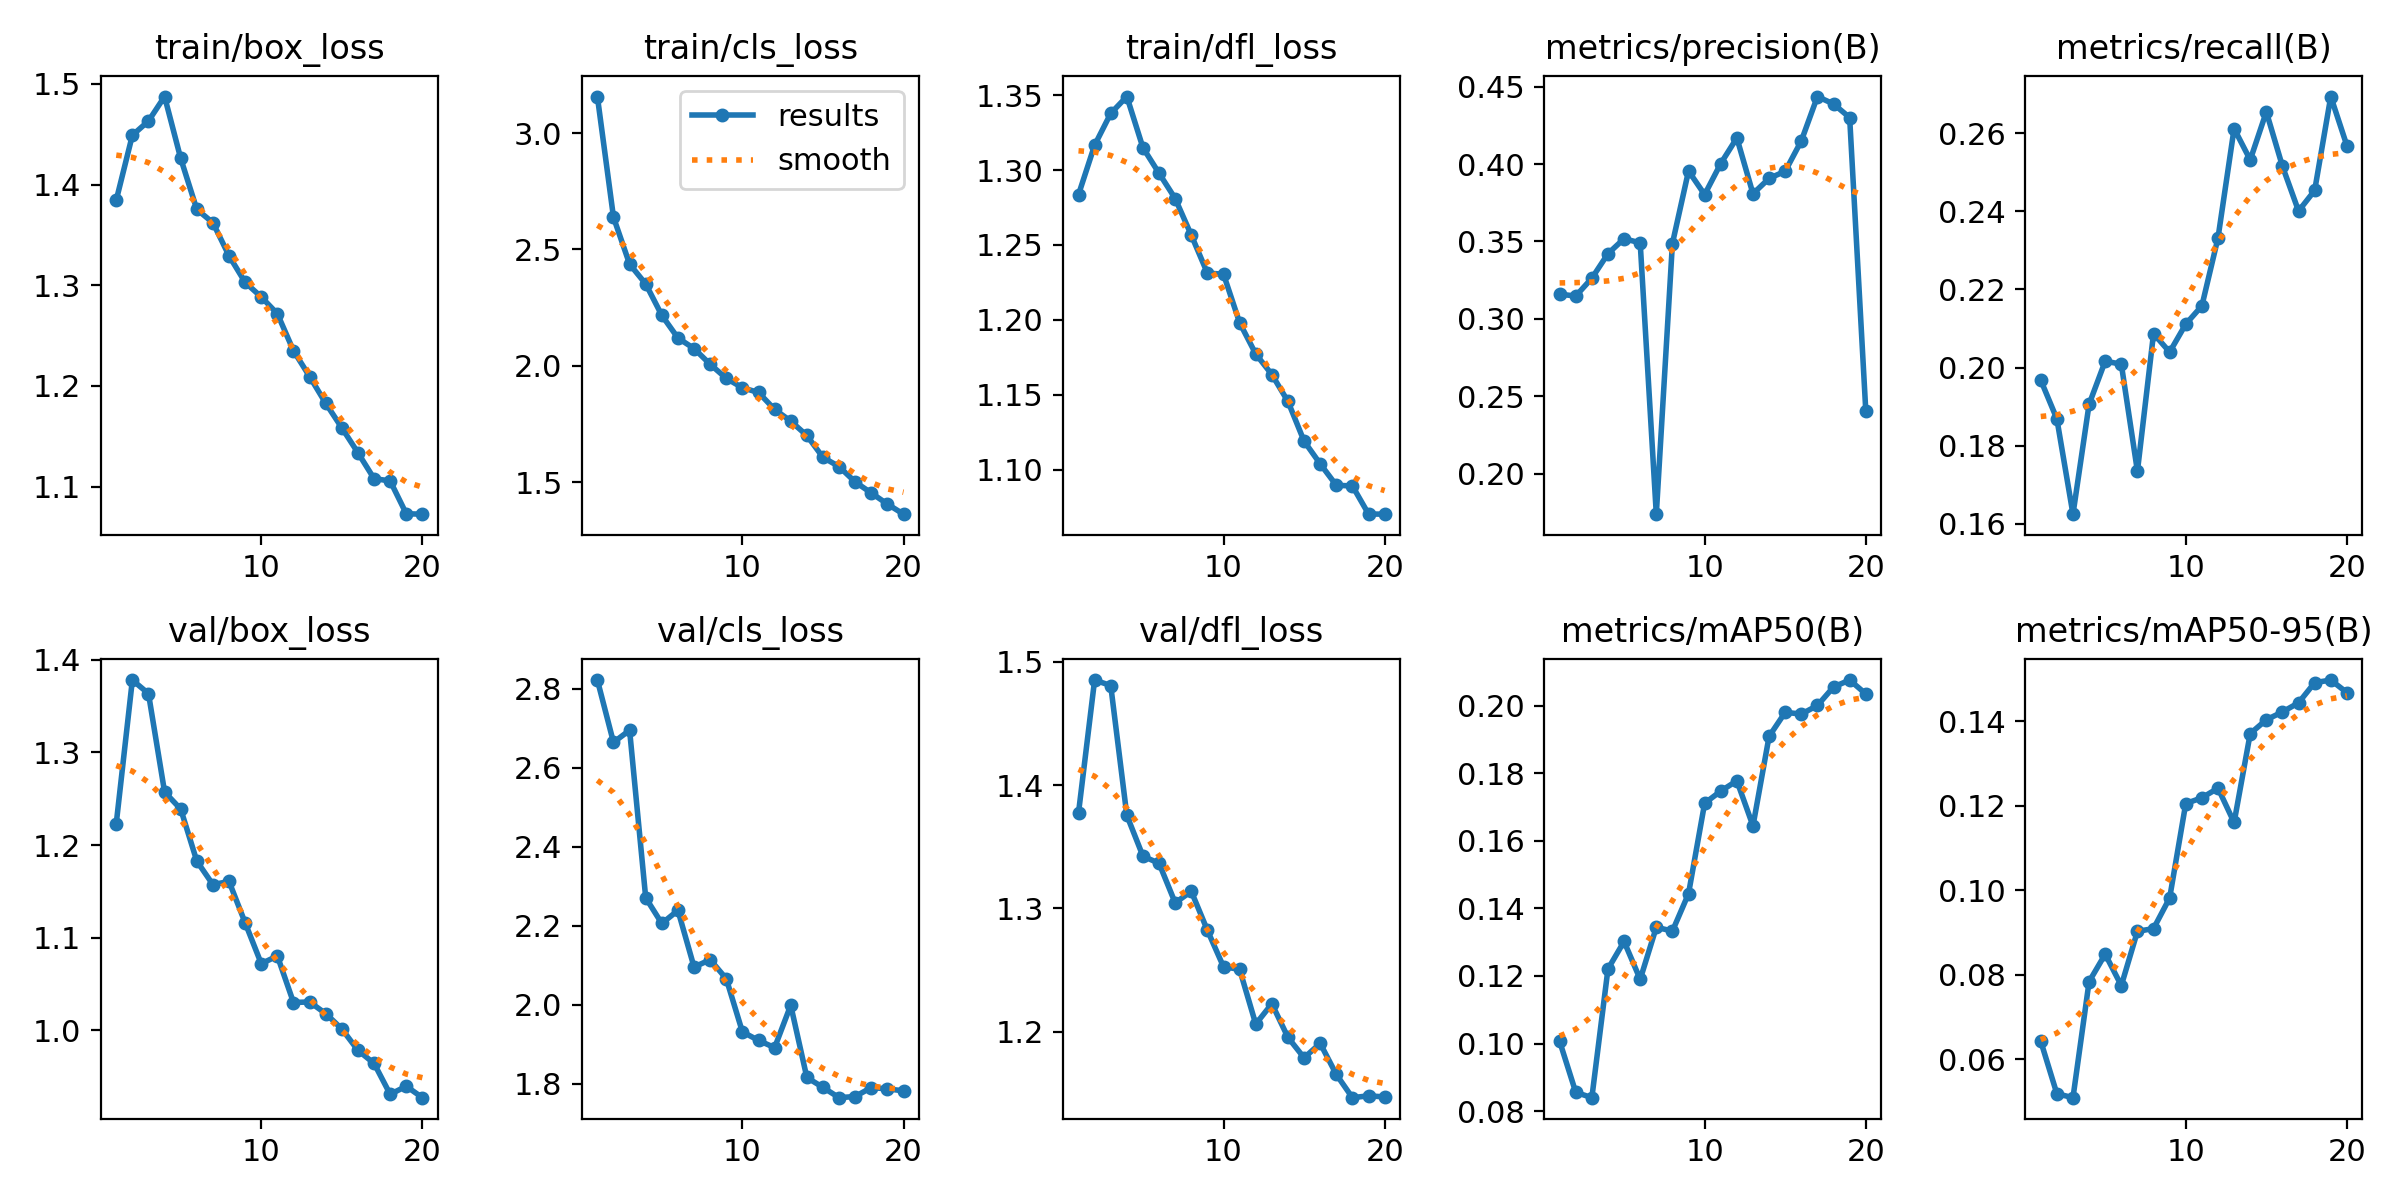

The training curves look very healthy: all three losses (box, class, DFL) decline smoothly in tandem on both train and val sets with no signs of over-fitting, and precision, recall and mAP steadily rise—mAP50 doubling and mAP50-95 more than doubling by epoch 20.
Overall, these results show robust learning dynamics and room for incremental mAP improvements with a gentler learning rate decay.

### YOLO generalization performance

In [19]:
# Evaluate on validation set
val_results = best_model.val(data=str(DATA_YAML), split='val')

# mAP@0.5
print(f"VAL mAP@0.5    = {val_results.box.map50:.3f}")

# mAP@0.75 (optional)
print(f"VAL mAP@0.75   = {val_results.box.map75:.3f}")

# mAP@0.5:0.95
print(f"VAL mAP@0.5:0.95 = {val_results.box.map:.3f}") # computed over the IoU range of 0.50 to 0.95.

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 89.0MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1813.8±696.5 MB/s, size: 49.4 KB)



val: Scanning /content/waste_detection/valid/labels... 580 images, 0 backgrounds, 0 corrupt: 100%|██████████| 580/580 [00:00<00:00, 2370.03it/s]

val: New cache created: /content/waste_detection/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:08<00:00,  4.35it/s]


                   all        580       1319       0.43      0.269      0.208       0.15
                 Glass         51         69          1          0     0.0256     0.0209
                 Metal        123        209      0.336      0.416      0.264      0.203
                 Paper        142        267      0.267      0.217      0.187      0.127
               Plastic        393        633      0.414      0.586      0.495      0.358
                 Waste         92        141      0.134      0.128      0.067     0.0412
Speed: 0.9ms preprocess, 4.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val
VAL mAP@0.5    = 0.208
VAL mAP@0.75   = 0.161
VAL mAP@0.5:0.95 = 0.150


In [20]:
# Evaluate on test set
test_results = best_model.val(data=str(DATA_YAML), split='test')

# mAP@0.5
print(f"VAL mAP@0.5    = {test_results.box.map50:.3f}")

# mAP@0.75 (optional)
print(f"VAL mAP@0.75   = {test_results.box.map75:.3f}")

# mAP@0.5:0.95
print(f"VAL mAP@0.5:0.95 = {test_results.box.map:.3f}") # computed over the IoU range of 0.50 to 0.95.

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1547.3±490.9 MB/s, size: 51.7 KB)


val: Scanning /content/waste_detection/test/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 2293.03it/s]

val: New cache created: /content/waste_detection/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


                   all         45        159      0.472      0.281      0.204      0.149
                 Glass          1         26          1          0          0          0
                 Metal          6         13       0.27      0.462      0.284      0.232
                 Paper         15         28      0.386      0.321      0.238       0.16
               Plastic         33         70      0.436      0.486      0.396      0.293
                 Waste         11         22      0.268      0.136      0.103     0.0585
Speed: 7.1ms preprocess, 7.6ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val2
VAL mAP@0.5    = 0.204
VAL mAP@0.75   = 0.162
VAL mAP@0.5:0.95 = 0.149


**Class-by-class analysis**

1.   Plastic is by far the strongest class (mAP50 ~0.40), probably because it has the most examples (70 instances).
2.   Metal and Paper are middling (~0.28 and ~0.24 mAP50).
3.   Waste is especially weak (mAP50 ≈ 0.10).
4.   Glass suffers from having only one validation image: precision is “1.0” because YOLO didn’t predict anything (so no false positives), but recall is zero.

**Possible improvement strategies**

1. Balance the dataset over-sampling minority classes.
2. Hyperparameter search.
3. Model capacity. Try larger YOLO model.
4. Post-processing thresholds. Adjust conf and iou thresholds at test time to trade off precision vs. recall for each class.


In [21]:
# Randomly selects two images from a specified dataset split and visualizes them
# with their ground truth and predicted bounding boxes

def visualize_random_images_with_predictions(dataset_dir: str,
                                              split: str,
                                              class_names: list[str],
                                              seed: int = 42) -> None:
    """
    Visualizes two random images from a dataset split with ground truth (top) and predictions (bottom).

    Args:
      dataset_dir: path to 'waste_detection' folder
      split: 'train', 'valid', or 'test'
      model_path: path to the trained YOLO model (e.g., 'best_model.pt')
      class_names: list of class names
      seed: random seed for reproducibility
    """
    random.seed(seed)

    images_dir = os.path.join(dataset_dir, split, 'images')
    labels_dir = os.path.join(dataset_dir, split, 'labels')
    all_images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    selected_images = random.sample(all_images, 2)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{split.upper()} - Top: Ground Truth | Bottom: Predictions', fontsize=14)

    for idx, img_name in enumerate(selected_images):
        img_path = os.path.join(images_dir, img_name)
        label_path = os.path.join(labels_dir, Path(img_name).stem + '.txt')

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gt = img.copy()
        img_pred = img.copy()

        # Draw ground truth boxes
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    cls_id, x_center, y_center, width, height = map(float, parts)
                    h, w, _ = img.shape
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)

                    cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img_gt, class_names[int(cls_id)], (x1, y1-5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

        # Predict and draw predicted boxes
        results = best_model.predict(img_path, conf=0.25, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()

        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_pred, class_names[int(cls)], (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

        # Plot
        axs[0, idx].imshow(img_gt)
        axs[0, idx].axis('off')
        axs[0, idx].set_title(f"Ground Truth: {img_name}",
                              fontsize = 10)

        axs[1, idx].imshow(img_pred)
        axs[1, idx].axis('off')
        axs[1, idx].set_title(f"Predictions: {img_name}",
                              fontsize = 10)

    plt.tight_layout()
    plt.show()

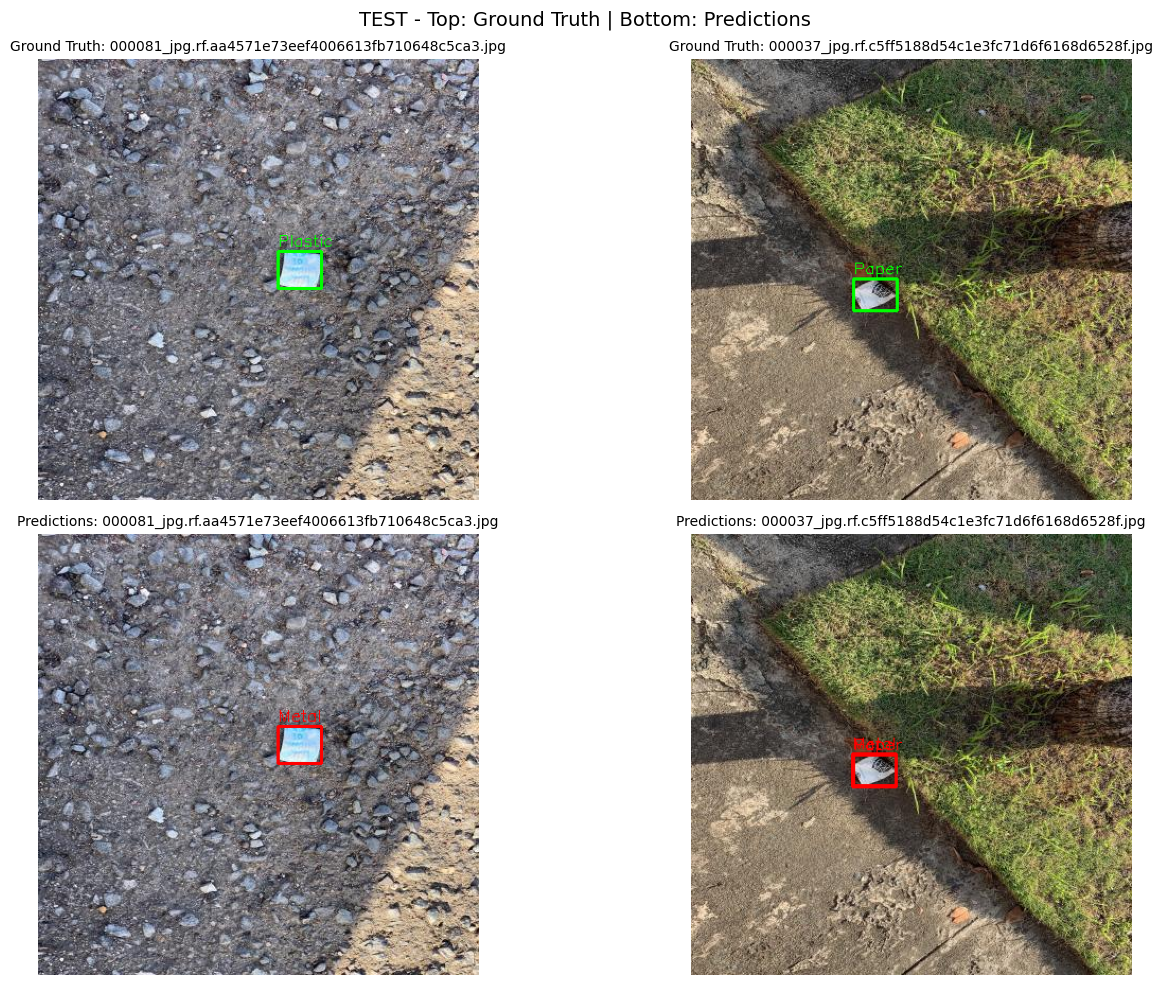

In [22]:
visualize_random_images_with_predictions(
    dataset_dir= base_path,
    split='test',
    class_names=['Glass', 'Metal', 'Paper', 'Plastic', 'Waste'],
    seed=123
)

In [23]:
# To test the generalization performance of the trained YOLO model,
# I took a picture at home of some waste to see if the model could correctly predict and detect the objects.

def visualize_predictions_on_all_images(images_folder: str, class_names: list[str]) -> None:
    """
    Reads all images in the folder, predicts bounding boxes using the loaded YOLO model,
    and visualizes the images with predicted boxes and class names.

    Args:
        images_folder: path to folder containing images
        class_names: list of class names
    """
    all_images = [f for f in os.listdir(images_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    for img_name in all_images:
        img_path = os.path.join(images_folder, img_name)

        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Predict
        results = best_model.predict(img_path, conf=0.25, verbose=False)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()

        # Draw predicted boxes
        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, class_names[int(cls)], (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 1)

        # Show image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predictions: {img_name}", fontsize=12)
        plt.show()


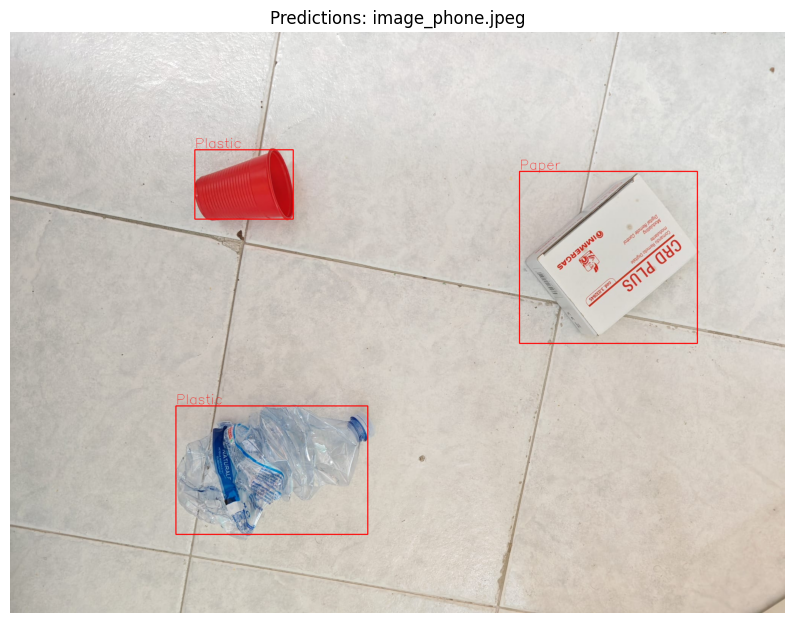

In [25]:
# Path to your images
images_folder = '/content/Image'

# Call the function
visualize_predictions_on_all_images(images_folder, class_names)